# (연습) 기댓값과 분산

**기본 설정**

Numpy와 Pandas 라이브러리를 각각 np와 pd로 불러온다.

In [1]:
import numpy as np
import pandas as pd

데이터프레임의 [chained indexing을 금지시키기 위한 설정](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy)을 지정한다.
Pandas 3.0 버전부터는 기본 옵션으로 지정된다.

In [2]:
pd.options.mode.copy_on_write = True

주피터 노트북에서 부동소수점의 출력을 소수점 이하 6자리로 제한한다.
아래 코드는 주피터 노트북에서만 사용하며 일반적인 파이썬 코드가 아니다.

In [3]:
%precision 6

'%.6f'

아래 코드는 데이터프레임 내에서 부동소수점의 출력을 소수점 이하 6자리로 제한한다.

In [4]:
pd.set_option('display.precision', 6)

데이터 시각화를 위해 `matplotlib.pyplot`를 `plt`라는 별칭으로 불러온다.

In [5]:
import matplotlib.pyplot as plt

**데이터 저장소 디렉토리**

코드에 사용되는 [데이터 저장소의 기본 디렉토리](https://github.com/codingalzi/DataSci/tree/master/data)를 지정한다.

In [6]:
data_url = 'https://raw.githubusercontent.com/codingalzi/DataSci/refs/heads/master/data/'

**문제 1**

아래 코드는 타이타닉호의 승객에 대한 정보와 생존 여부를 담은 데이터셋을 불러와서
다음 전처리를 실행한다.
코드에 대한 보다 자세한 설명은
[(연습) 인산 확률 분포](https://colab.research.google.com/github/codingalzi/DataSci/blob/master/practices/practice-probability_discrete.ipynb)를
참고한다.

- `PassengerId` 특성을 인덱스로 지정
- `Embarked` 특성의 결측치를 모두 해당 특성의 최빈값으로 대체
- `Age` 특성의 결측치를 성(Sex)별 중앙값으로 대체
- `Age` 특성을 10살 단위로 구분하는 연령구간을 지정하여 `Age_Bucket` 특성으로 추가

In [7]:
titanic = pd.read_csv(data_url+"titanic.csv")
titanic = titanic.set_index("PassengerId")

embarked_mode =(titanic['Embarked'].mode().values)[0]
titanic['Embarked'] = titanic['Embarked'].fillna(embarked_mode)

f_mask = titanic["Sex"]=="female"
f_age_median = titanic.loc[f_mask, "Age"].median()
m_age_median = titanic.loc[~f_mask, "Age"].median()

titanic.loc[f_mask, 'Age'] = titanic.loc[f_mask, 'Age'].fillna(f_age_median)
titanic.loc[~f_mask, 'Age'] = titanic.loc[~f_mask, 'Age'].fillna(m_age_median)

titanic['Age_Bucket'] = (titanic["Age"] // 10 * 10).astype('i8')

확률 변수 $X$가 타이타닉 데이터셋에서 임의로 선택된 사람의 나이대를 가리킨다고 하면
아래 `prob_age` 변수가 확률 변수 `X`에 대한 확률 분포를,
`f_age()` 함수는 확률 질량 함수를 가리킨다.

In [8]:
age_stratified_count = titanic.loc[:, ['Age_Bucket', 'Age']].groupby('Age_Bucket', observed=True, group_keys=True).count()
age_stratified_ratio = age_stratified_count / len(titanic)

# 데이터프레임으로 변환
prob_age = age_stratified_ratio.iloc[:, 0:1]
# 컬럼과 인덱스 이름 지정
prob_age.columns = ['확률']
prob_age.index.name = 'X'

# 가로형의 데이터프레임으로 변환
prob_age = prob_age.T

In [9]:
prob_age

X,0,10,20,30,40,50,60,70,80
확률,0.069585,0.114478,0.445567,0.18743,0.099888,0.053872,0.021324,0.006734,0.001122


In [10]:
def f_age(x):
    return prob_age[x].iloc[0]

(1) 확률 변수 `X`의 기댓값을 가리키는 변수 `mu_age`를 선언하라.

답:

기댓값 계산을 위해 아래 정의를 이용한다.

$$
E[X] = x_1 \, f(x_1) + \cdots + x_n \, f(x_n) = \sum_{i=1}^{n} x_i \, f(x_i) \\[.5ex]
$$

In [11]:
mu_age = np.sum([x * f_age(x) for x in range(0, 81, 10)])
print(f"나이 기댓값: {mu_age:.1f}살")

나이 기댓값: 24.2살


(2) 확률 변수 `X`의 표준편차를 가리키는 변수 `sigma_age`를 선언하라.

답:

분산 계산을 위해 아래 정의를 이용한 다음에 제곱근을 계산하면 표준편차를 얻는다.

$$
V(X) = E[(X - \mu_X)^2] = \sum_{i=1}^n (x_i -\mu_X)^2 \, f(x_i)
$$

In [12]:
V_age = np.sum([(x - mu_age)**2 * f_age(x) for x in range(0, 81, 10)])
sigma_age = np.sqrt(V_age)

print(f"나이 표준편차: {sigma_age:.1f}살")

나이 표준편차: 13.6살


(3) 확률 변수 `X`가 가리키는 나이대는 10살 기준으로 구분하였다.
나이대별 평균 나이를 가리키는 확률 변수 `Y`를 확률 변수 `X`의 선형 변환으로 정의하라.

답:

사람들의 실제 나이는 나이대별로 평균적으로 5살을 더하는 게 적절해 보인다
따라서 확률 변수 `X`에 5를 더하여 확률 변수 $Y$를 지정한다.

$$
Y = X + 5
$$

(4) 확률 변수 `Y`의 기댓값과 표준편차를 확률 변수 선형 변환 공식을 이용하여 계산하라.

답:

확률 변수 $Y = a\, X + b$의 기댓값, 분산, 표준편차는 다음과 같이 계산된다.

$$
\begin{align*}
E[Y] &= a \,E[X] + b \\[1ex]
V(Y) &= a^2 \, V(X) \\[1ex]
\sigma_Y &= |a|\, \sigma_X
\end{align*}
$$

- 나이대별 평균 나이의 기댓값

In [13]:
mu_Y = mu_age + 5
mu_Y

29.208754

- 나이대별 평균 나이의 표준편차

In [14]:
sigma_Y = sigma_age
sigma_Y

13.555273

**문제 2 (포아송 분포)**

어떤 사건이 단위 시간 내에 발생하는 횟수를 가리키는 이산 확률 변수의 분포를
**포아송 분포**<font size='2'>Poisson distribution</font>라 부른다.

예를 들어, 일평균 $\lambda$ 명의 응급환자가 발생하는 병원에서 하룻동안 발생하는 응급환자의 수를
확률 변수 `X`가 가리킨다고 하자.
그러면 하루에 $x$ 명의 응급환자가 발생할 확률을 계산하는
확률 질량 함수는 다음과 같다.

$$
f(x) = \frac{\lambda^x\, e^{-\lambda}}{x!}
$$

단, $x$는 음이 아닌 정수를 가리킨다.

그러면 확률 변수 `X`에 대한 기댓값과 분산은 다음과 같다.

$$
E[X] = \lambda, \qquad V(X) = \lambda
$$

아래 `poi()` 함수는 포아송 분포의 확률 질량 함수를 구현하며
두 개의 매개 변수를 사용한다.

- `lam`: $\lambda$ 에 해당하는 값, 즉 단위 시간 당 사건 평균 발생 횟수.
- `x`: 확률 변수 $X$가 가리키는 값, 즉 단위 시간 당 사건 발생 횟수. 단 0에서 19까지만 값을 취함.
    `x`가 20 이상이면 $f(x)$는 사실상 0으로 간주될 정도로 매우 작음.

In [15]:
from scipy.special import factorial

def poi(lam, x):
    if x in range(20):
        return np.power(lam, x) * np.exp(-lam) / factorial(x)
    else:
        return 0

하루 평균 5명의 응급환자가 발생한다고 가정하자.
즉, $\lambda = 5$로 지정한다.

(1) 병원에서 하루에 2명의 응급환자가 발생할 확률을 계산하라.

답:

In [16]:
poi(5, 2)

0.084224

(2) 병원에서 하루에 3명에서 5명 사이의 응급환자가 발생할 확률을 계산하라.

답:

In [18]:
np.sum([poi(5, x) for x in range(3, 6)])

0.491309

(3) 확률 변수 `X`의 기댓값과 분산이 5로 계산됨을 확인하라.

답:

- 기댓값

In [35]:
mu_poi5 = np.sum([x * poi(5, x) for x in range(20)])
print(f"기댓값: {mu_poi5:.2f}")

기댓값: 5.00


- 분산

In [36]:
V_poi5 = np.sum([(x - mu_poi5)**2 * poi(5, x) for x in range(20)])
print(f"분산: {V_poi5:.2f}")

분산: 5.00


(4) 확률 변수 `X`의 확률 분포, 즉 $\lambda=5$일 때의 포아송 분포를 (막대) 그래프로 그려라.

답:

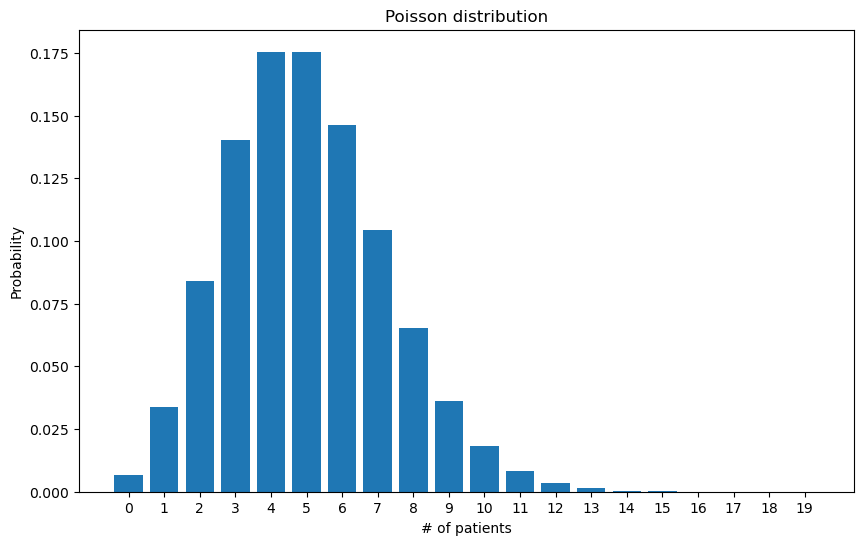

In [30]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

xs = np.arange(20)
ys = np.array([poi(5, x) for x in xs])

ax.bar(xs, ys)
ax.set_title('Poisson distribution')
ax.set_xlabel('# of patients')
ax.set_ylabel('Probability')

ax.set_xticks(np.arange(20))
ax.set_xticklabels(range(0,20))

plt.show()

아래 그래프는 포아송 분포와 함께 기댓값도 함께 표시한다.

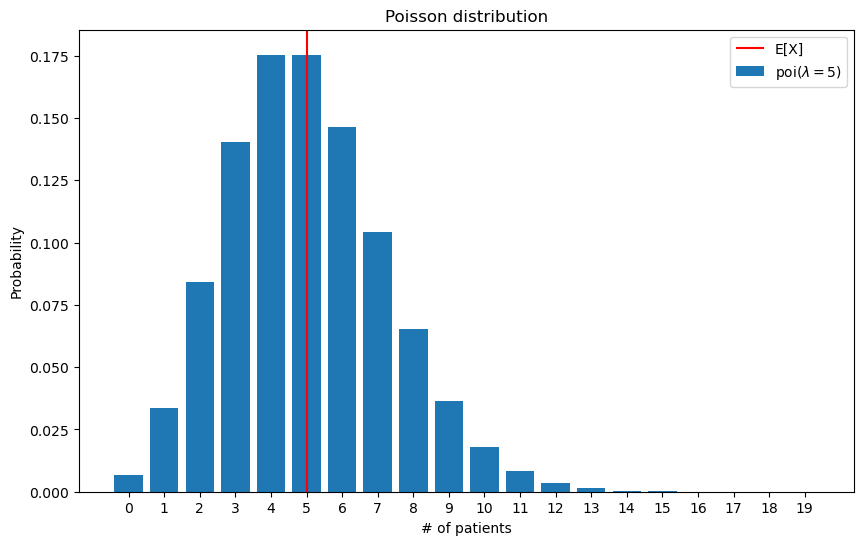

In [49]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

xs = np.arange(20)
ys = np.array([poi(5, x) for x in xs])

ax.bar(xs, ys, label=r'poi($\lambda=5$)')
ax.set_title('Poisson distribution')
ax.set_xlabel('# of patients')
ax.set_ylabel('Probability')

ax.vlines(mu_poi5, 0, max(ys)+0.01, label='E[X]', color='red')

ax.set_xticks(np.arange(20))
ax.set_xticklabels(range(0,20))
ax.set_ylim(0, max(ys)+0.01)

ax.legend()

plt.show()

**문제 3**

`scipy.stats` 모듈의 `poisson` 객체가 포아송 분포의 모든 것을 메서드로 제공한다.

In [50]:
from scipy.stats import poisson

In [55]:
lam = 5

In [58]:
poisson.pmf(range(20), lam)

array([6.737947e-03, 3.368973e-02, 8.422434e-02, 1.403739e-01,
       1.754674e-01, 1.754674e-01, 1.462228e-01, 1.044449e-01,
       6.527804e-02, 3.626558e-02, 1.813279e-02, 8.242177e-03,
       3.434240e-03, 1.320862e-03, 4.717363e-04, 1.572454e-04,
       4.913920e-05, 1.445271e-05, 4.014640e-06, 1.056484e-06])

<BarContainer object of 20 artists>

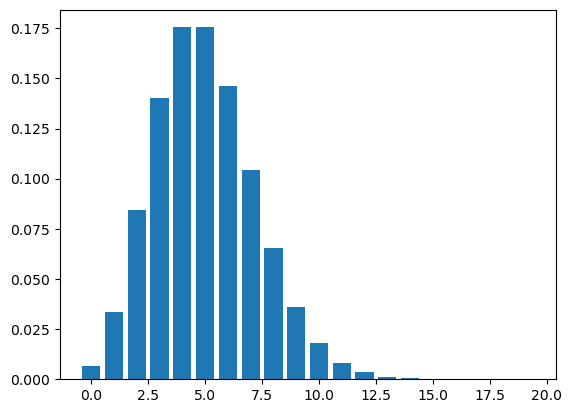

In [60]:
plt.bar(range(20), poisson.pmf(range(20), lam))